<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/Insomnia_ARIMA_Predictions_NK_4_30_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team Insomnia - Stock Prediction ARIMA Model

# Imports

In [86]:
#Install statsmodels to get ARIMA
!pip install statsmodels
#Install pmdarima to get auto ARIMA
!pip install pmdarima

In [87]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA       #ARIMA model
from pmdarima import auto_arima #Auto ARIMA
import matplotlib.pyplot as plt                     # ploting Graphs
from statsmodels.graphics.tsaplots import plot_acf  # ploting more Graphs
from pmdarima.arima.utils import ndiffs             # for ndiffs evaluation
from statsmodels.graphics.tsaplots import plot_pacf # partial graphs



In [88]:
#Yahoo finance data
import yfinance as yf
start_date = '2012-03-11',
end_date='2022-07-10',
data = yf.download(tickers='ADM')

[*********************100%%**********************]  1 of 1 completed


In [89]:
#Manually coded to get the timeframe similar to LSTM
dataYears = data[8070:10669]


##Import Data from Files

Note: msi and xom have been scrapped in favor of LSTM.
adm is included just to show work for the ARIMA model.

In [90]:


adm_df = dataYears #Redefining
#Test size
testSize = 500

#Just the date and Closing Column
adm_closing_prices = adm_df['Close'][0:len(adm_df['Close'])-testSize] #Training Data

admOpen =  adm_df['Open'][0:len(adm_df['Open'])-testSize]
admHigh = adm_df['High'][0:len(adm_df['High'])-testSize]
admLow = adm_df['Low'][0:len(adm_df['Low'])-testSize]
admVolume= adm_df['Volume'][0:len(adm_df['Volume'])-testSize]

admOpenTest = adm_df['Open'][len(adm_df['Open'])-testSize:len(adm_df['Open'])]
admHighTest = adm_df['High'][len(adm_df['High'])-testSize:len(adm_df['High'])]
admHighLow = adm_df['Low'][len(adm_df['Low'])-testSize:len(adm_df['Low'])]
admVolumeTest= adm_df['Volume'][len(adm_df['Volume'])-testSize:len(adm_df['Volume'])]


admTest = adm_df['Close'][len(adm_df['Close'])-testSize:len(adm_df['Close'])] #Testing Data

msi_closing_prices = msi_df['Close'][0:len(msi_df['Close'])-testSize] #Train
msiTest = msi_df['Close'][len(msi_df['Close'])-testSize:len(msi_df['Close'])] #Test

xom_closing_prices = xom_df['Close'][0:len(xom_df['Close'])-testSize] #Train
xomTest = xom_df['Close'][len(xom_df['Close'])-testSize:len(xom_df['Close'])] #Test

In [91]:
#Testing which variables are independent
#For all intents and purposes, volume is independent
adm_closing_prices.corr(admVolume) #Change parameter to compare with adm_closing_prices


-0.29657195025656247

In [92]:
#First one is independent variables only, second also includes dependent variables
#Need to uncomment/recomment parts to specify which version you want.
#exoDataframe=pd.DataFrame([admVolume]).transpose()
exoDataframe=pd.DataFrame([admVolume, admHigh, admLow, admOpen]).transpose()
print(exoDataframe)
print(admTest)


               Volume       High        Low       Open
Date                                                  
2012-03-12  3293200.0  31.440001  31.129999  31.209999
2012-03-13  4516300.0  32.220001  31.450001  31.450001
2012-03-14  4268700.0  32.189999  31.540001  32.139999
2012-03-15  3237700.0  31.820000  31.400000  31.770000
2012-03-16  4986200.0  31.940001  31.620001  31.740000
...               ...        ...        ...        ...
2020-07-08  2520300.0  39.380001  38.430000  39.200001
2020-07-09  2281700.0  38.490002  37.540001  38.480000
2020-07-10  1869300.0  39.400002  37.900002  37.900002
2020-07-13  3270200.0  40.150002  39.540001  39.759998
2020-07-14  2169700.0  40.570000  39.439999  39.790001

[2099 rows x 4 columns]
Date
2020-07-15    40.900002
2020-07-16    40.959999
2020-07-17    41.169998
2020-07-20    40.220001
2020-07-21    40.860001
                ...    
2022-07-01    76.410004
2022-07-05    72.379997
2022-07-06    72.220001
2022-07-07    74.400002
2022-07-08    7

#Test Data
Testing data statistically through stationary checks and seasonality checks.
Testing data graphically by plots.

Notes: Review video for process understanding  https://www.youtube.com/watch?v=gqryqIlvEoM

In [93]:
#Check to see if it needs to be made stationary
#Uses adfuller test with null hypothesis that the series is stationary.
#P-value is between 0 and 1 and tests signfigance of the null hypothesis.
#If P>0.05: enough evidence exists to consider that the null hypothesis is true and the data is stationary.
#If P < 0.05: enough evidence exists to suggest the time series is not stationary

from statsmodels.tsa.stattools import adfuller
def checkStationary(timeSeries):
  resultFuller =  adfuller(timeSeries.dropna())
  print(f"ADF statistic : {resultFuller[0]}")
  print(f"p-value: {resultFuller[1]}")






In [94]:
#Check if time series has seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(adm_df['Close'], model='additive', period=365)
if np.abs(decomposition.seasonal.mean()) > 0.05:
    print("The time series has seasonality.")
else:
    print("The time series does not have seasonality.")

The time series does not have seasonality.


In [95]:
#Plot Auto correlation of a time series
#titleName is just to make reference to which time series is being plotted when this function is called
def plotACF(timeSeries, titleName):
  # Corrolation between serias and its lags
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
  ax1.plot(timeSeries)
  ax1.set_title(titleName)
  plot_acf(timeSeries, ax=ax2);


#Partial auto correlation function, with same premise as ACF function above
from statsmodels.graphics.tsaplots import plot_pacf

def plotPACF(timeSeries, titleName):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
  ax1.plot(timeSeries)
  ax1.set_title(titleName)
  plot_pacf(timeSeries, ax=ax2)
  # Set the y-axis limits explicitly for ax2
  plt.show()



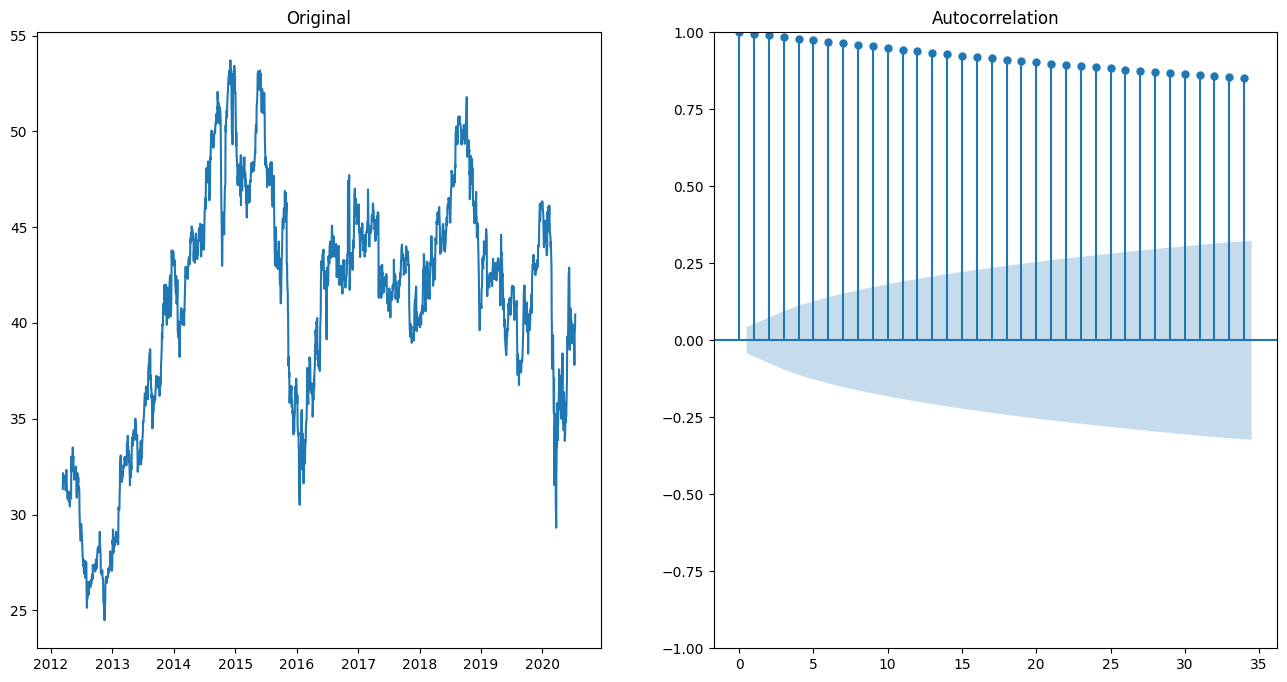

In [96]:
#Plot ACF
plotACF(adm_closing_prices, "Original")

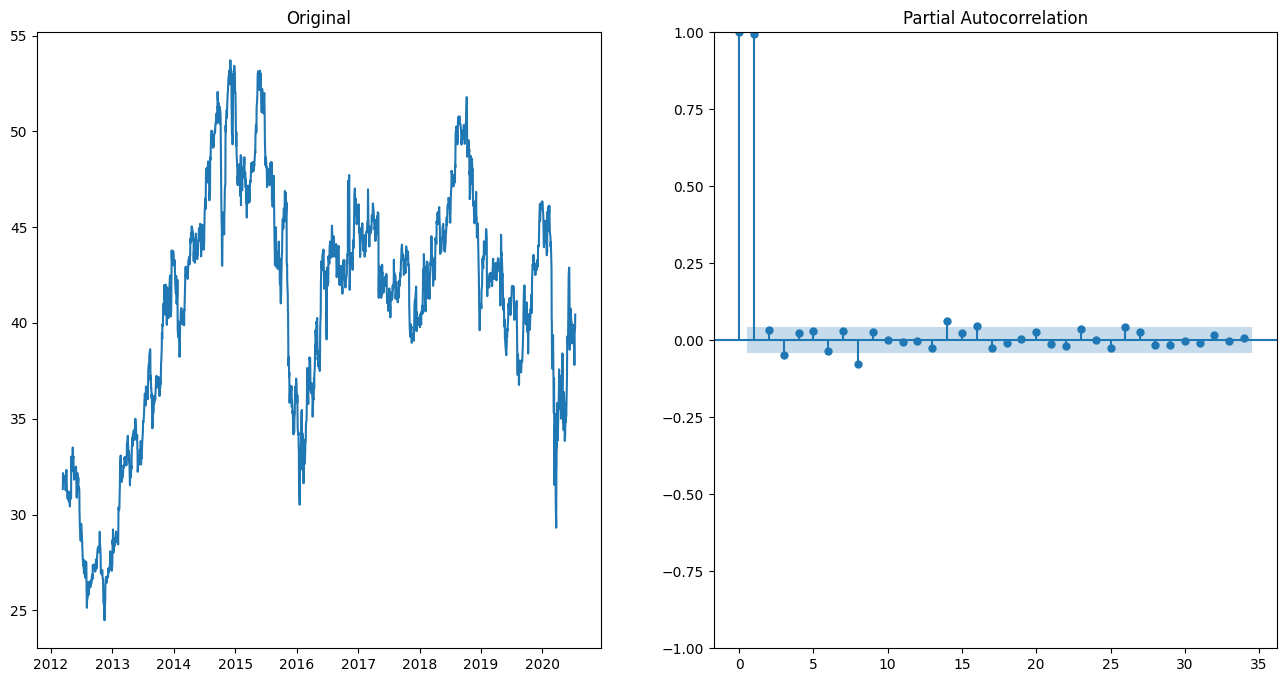

In [97]:
#Plot PACF
plotPACF(adm_closing_prices, "Original")
#For adm, the ACF plot decays steadily while the PACF plot drops instantly.
#This implies that an AR model would be the best fit for the data.

In [98]:

# To standardize the differential we need to know how many need to be taken.
#Used to see how many differentials should be taken
diff_num = ndiffs(adm_closing_prices, test="adf")
print(f"Number of Diffrening to run in :{diff_num}")


def x_diffs(df_: pd.DataFrame, x: int) -> pd.DataFrame:
    if x == 0:
        return df_
    else:
        return x_diffs(df_.diff().dropna(), x - 1)




Number of Diffrening to run in :1


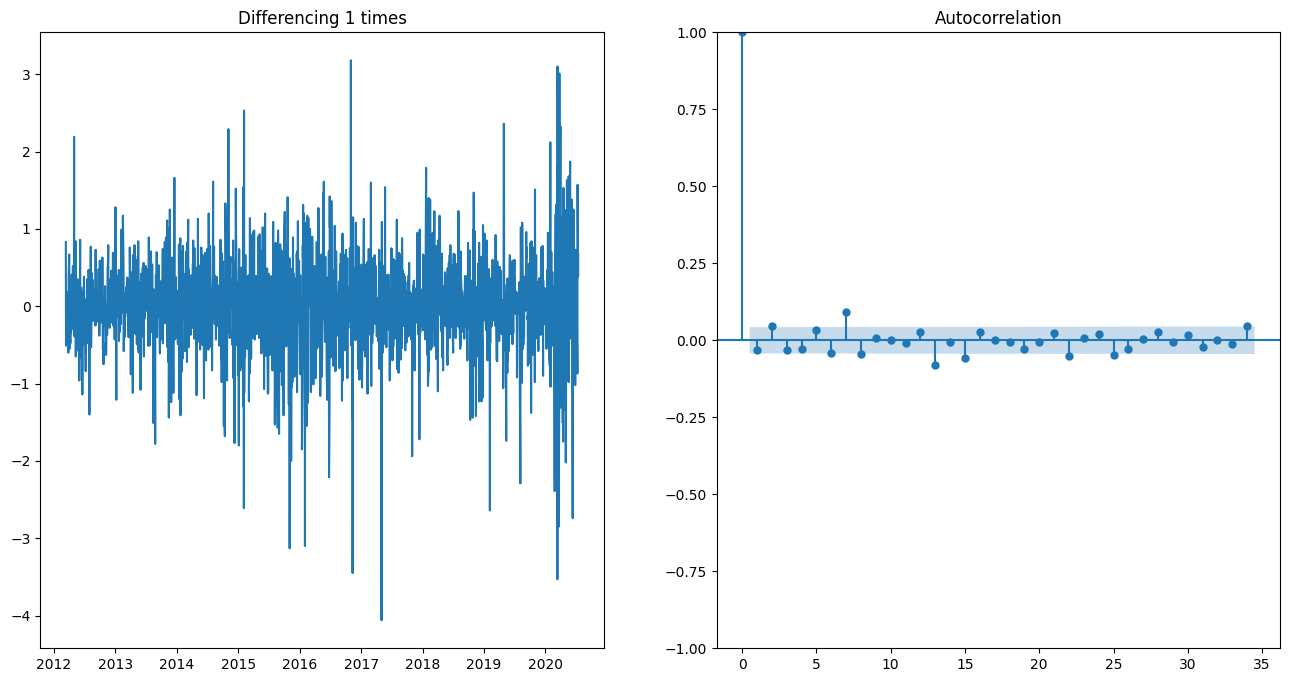

In [99]:
diff_x = x_diffs(adm_closing_prices,1)#Difference timeseries once

plotACF(diff_x, "Differencing 1 times") #Plot ACF of differenced timeseries


In [100]:
#Check stationary to see if it needs to be differenced again
checkStationary(diff_x) #Since P <0.05, diff_x is stationary


#Perform the same procedure for PACF
pdiff = adm_closing_prices.diff().dropna()

ADF statistic : -13.042493828761927
p-value: 2.226205133324011e-24


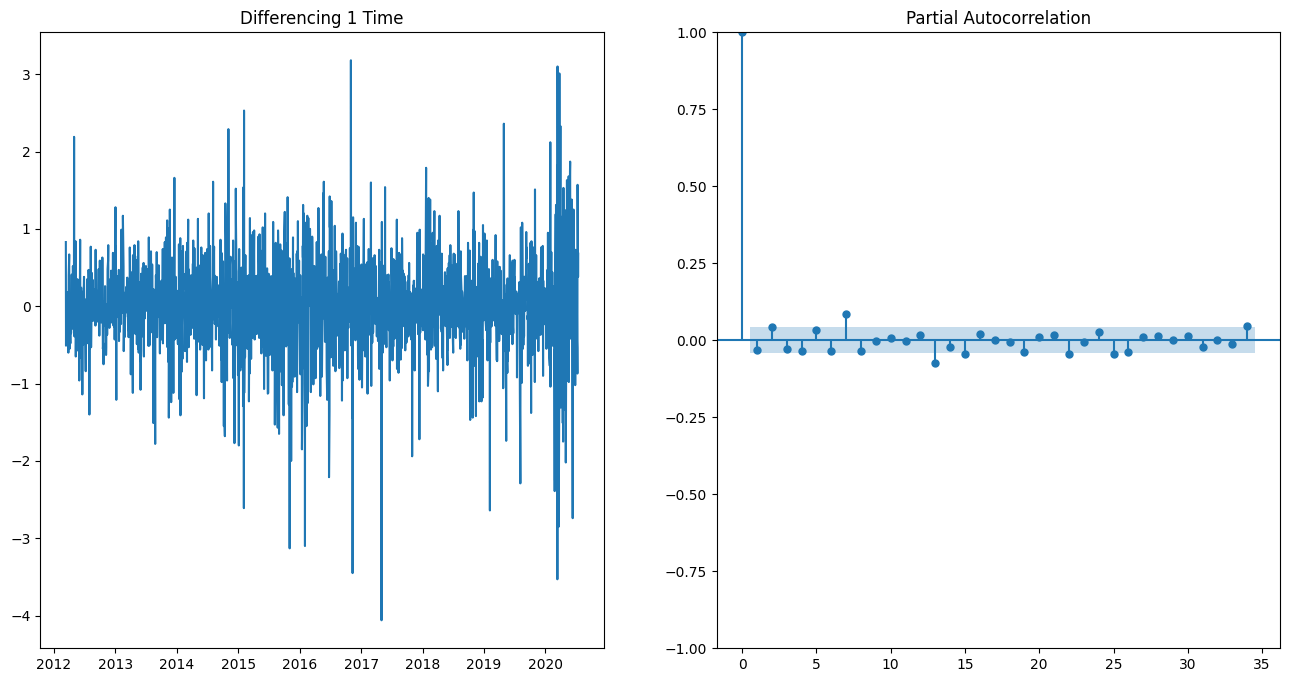

In [101]:
#Plot Partial Autocorrelation
plotPACF(pdiff, "Differencing 1 Time")

#Optimal ARIMA Parameters

By the ACF and PCAF plots in the last section, the type of model needed can be found.  However, to make it simple, autoARIMA implements a stepwise search to find the parameters to minimize the AIC curve.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-247.631, Time=1.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-254.755, Time=2.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-254.976, Time=3.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13708.186, Time=1.84 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-252.980, Time=5.25 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-253.057, Time=4.34 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-253.169, Time=4.40 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-256.849, Time=4.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-254.851, Time=3.61 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-254.928, Time=3.73 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-256.629, Time=1.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-255.056, Time=5.25 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 41.389 seconds
                               SARIMAX Results                                
Dep. Va

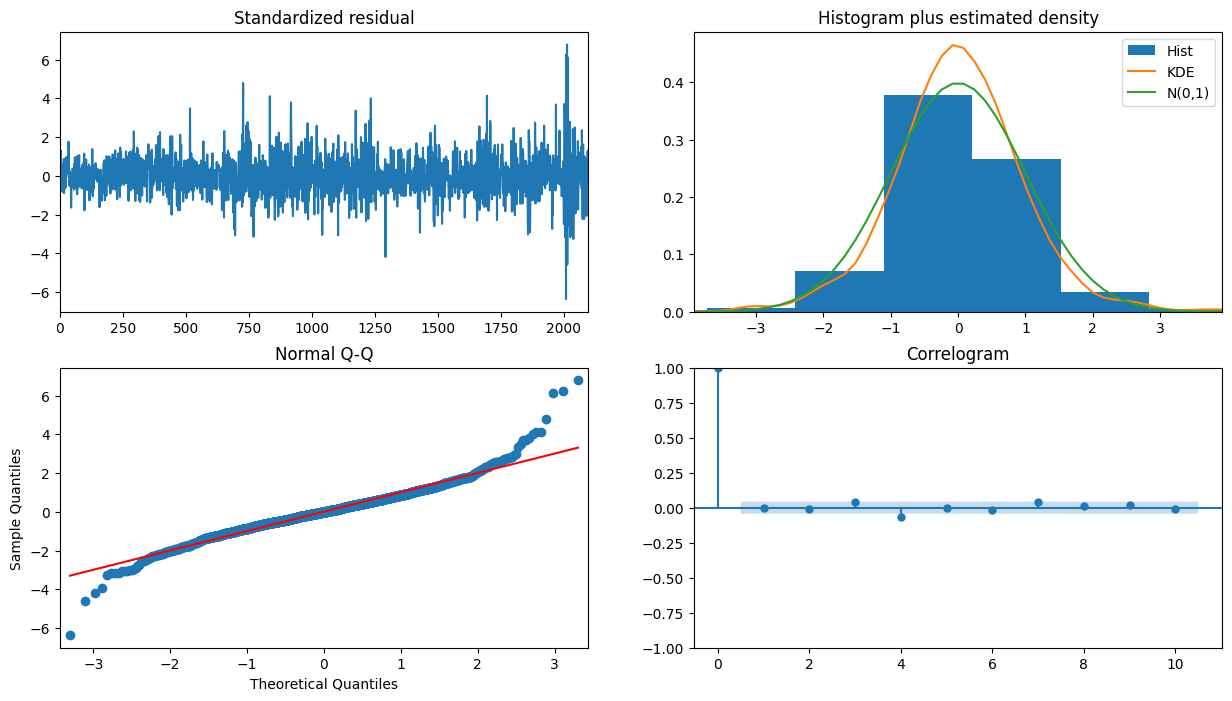

In [102]:



#Auto ARIMA to find optimal p, d, and q for ARIMA model.
#Finds optimal d by augmented Dickney-Fuller
#Does this by iterating between different values start_q, start_p and max_q, max_p until it finds the optimal combination.
#Says (1,0,0) is optimal (for 10 predictions)
#Says (2,0,0) is optimal (for 500 predictions)
#y=Data to predict
#X= exogeneous values that aid the training/testing

#Plug parameter results from auto_arima to model
model_autoARIMA = auto_arima(y=adm_closing_prices,
                             X=exoDataframe,
                             start_p=0,
                             start_q=0,
                      test='adf', #Augmented Dickey-Fuller to "supposedly" find optimal d
                      max_p=7, max_q=7, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonality = False, #Time series is not seasonal
                      trace=True) #Shows which values it is trying
print(model_autoARIMA.summary())

#Show useful graphs
#Standardized residuals: Rediual = predicted-observed.  Show prediction errors occured at timesteps specified on x-axis
#Histogram: Graphs of histogram, standard normal, and KDE*
#QQ-Plot: Each residual becomes a quantile in a distrubution. This (y-axis) is plotted the quantiles for a normal distribution.
#The closer the points are to the red line, the closer the redisuals represnt a normal distribution.
# Correlogram is another way of saying autocorrelation plot.  This particular ACF is for the prediction residuals of the timeseries, not the time series itself.


#*:places a smaller normal distribution or other kernel around each point and adds up the areas, very similar to an idea of a continuious histogram.
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [103]:
adm_df['Close']


Date
2012-03-12    31.330000
2012-03-13    32.160000
2012-03-14    31.650000
2012-03-15    31.820000
2012-03-16    31.799999
                ...    
2022-07-01    76.410004
2022-07-05    72.379997
2022-07-06    72.220001
2022-07-07    74.400002
2022-07-08    73.339996
Name: Close, Length: 2599, dtype: float64

# Build Model

In [104]:
# Fit the ARIMA model
#Arima combines auto regessive model and moving average model while calculating differences in the time series to make it stationary.
# The parameters for ARIMA are (p, d, q)
# p: periods taken for autoregressive model
# d: Integrated order, difference -> number of differences taken for stationarity.
# q: periods in moving average model


#Uses result from auto.arima
model = ARIMA(adm_closing_prices, order=model_autoARIMA.order,exog=exoDataframe)  # Example parameters


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [105]:
#Fit model
result = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [106]:
#Print model summary
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2099
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 138.361
Date:                Tue, 30 Apr 2024   AIC                           -262.721
Time:                        20:17:56   BIC                           -223.177
Sample:                             0   HQIC                          -248.237
                               - 2099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1062      0.001    147.876      0.000       0.105       0.108
Volume     -5.688e-09   2.88e-09     -1.973      0.049   -1.13e-08   -3.68e-11
High           0.8059      0.009     89.123      0.0

# Predictions

In [107]:
# Actual vs Fitted

#First one is independent variables only, second also includes dependent variables
#predValues = result.forecast(testSize, exog=adm_df[['Volume']].iloc[-testSize:].values)
predValues = result.forecast(testSize, exog=adm_df[['Volume', 'High','Low', 'Open']].iloc[-testSize:].values) #restrict exog variables to test data.
print(predValues)
print(admTest)

pTest = pd.DataFrame(predValues)
pTest.set_index(admTest.index, inplace=True)


2099    40.835024
2100    41.053957
2101    41.145102
2102    40.399543
2103    41.108381
          ...    
2594    75.597208
2595    72.150154
2596    71.575308
2597    75.159229
2598    73.907956
Name: predicted_mean, Length: 500, dtype: float64
Date
2020-07-15    40.900002
2020-07-16    40.959999
2020-07-17    41.169998
2020-07-20    40.220001
2020-07-21    40.860001
                ...    
2022-07-01    76.410004
2022-07-05    72.379997
2022-07-06    72.220001
2022-07-07    74.400002
2022-07-08    73.339996
Name: Close, Length: 500, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import math
mse = mean_squared_error(admTest, predValues)
print('MSE: '+str(mse))
mae = mean_absolute_error(admTest, predValues)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(admTest, predValues))
print('RMSE: '+str(rmse))


r2 = r2_score(admTest, predValues)
print("R Squared: " + str(r2))



MSE: 0.19095553003967308
MAE: 0.31901051993765234
RMSE: 0.43698458787430144
R Squared: 0.9989821491523989


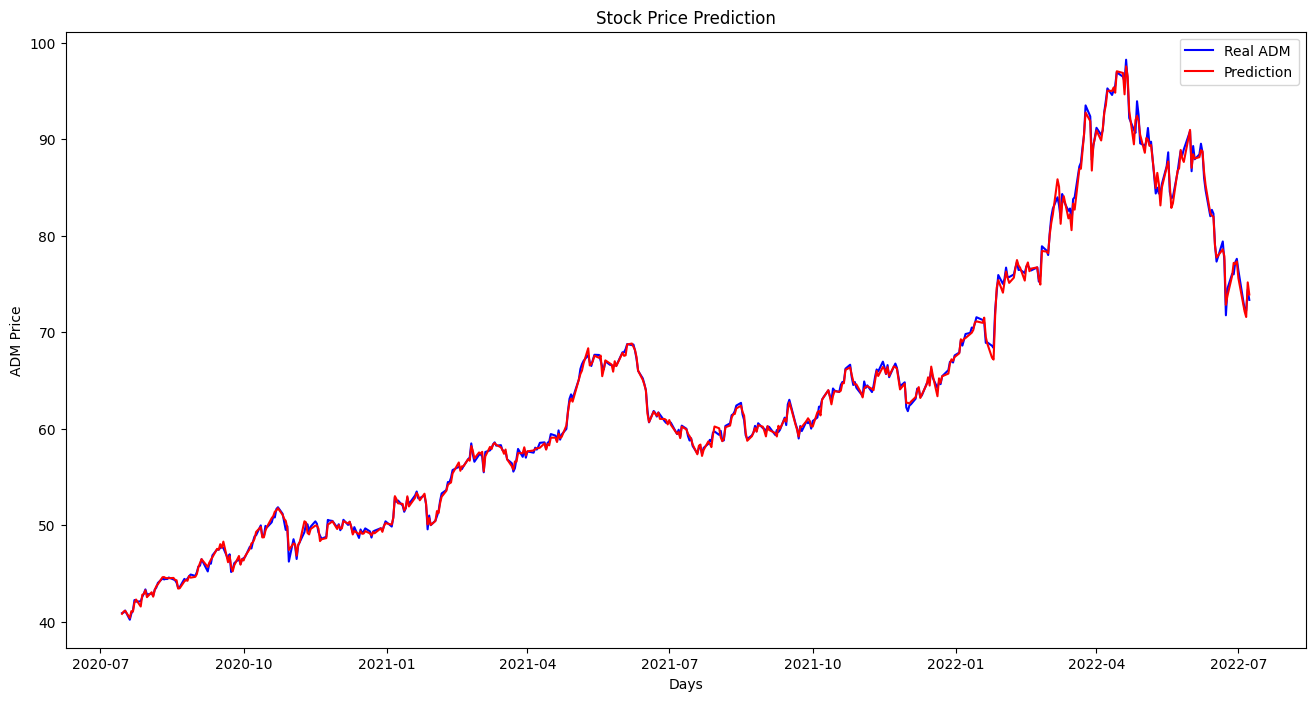

In [109]:
#Plot predictions

plt.figure(figsize=(16,8))
plt.plot(admTest, color = "blue", label = "Real ADM")
plt.plot(pTest, color = "red", label = "Prediction")
plt.title("Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("ADM Price")
plt.legend()
plt.show()


In [110]:
#Self-testing metrics
bigPred = [0]*testSize
predBias = [0]*testSize
absPred = [0]*testSize
moveCorrect = [0]*testSize

predValues.iloc[0]
i=0
while i < testSize:
  bigPred[i]= predValues.iloc[i]/admTest.iloc[i]
  predBias[i]=1- predValues.iloc[i]/admTest.iloc[i]
  absPred[i] = abs(1- predValues.iloc[i]/admTest.iloc[i])

  i=i+1
print("Overall Prediction Accuarcy:")
print(sum(bigPred)/testSize)
print("Bias")
print(sum(predBias)/testSize)
print("Absolute value difference accuracy:")
print(sum(absPred)/testSize)





Overall Prediction Accuarcy:
0.9991036431587265
Bias
0.0008963568412735712
Absolute value difference accuracy:
0.004894238271993896


#Other Predictions

This part of the code has been scrapped in favor of the LSTM method.  The results for the ARIMA on the ADM stock are above.  The code below will most definitely produce an error.

In [111]:

#declare filenames
#adm_file_path = '/content/drive/MyDrive/adm.us.txt'
#msi_file_path = '/content/drive/MyDrive/msi.us.txt'
#xom_file_path = '/content/drive/MyDrive/xom.us.txt'

#load files
#adm_df = pd.read_csv(adm_file_path)
#msi_df = pd.read_csv(msi_file_path)
#xom_df = pd.read_csv(xom_file_path)


# Create index of date column
#adm_df['Date'] = pd.to_datetime(adm_df['Date'])
#adm_df.set_index('Date', inplace=True)

#msi_df['Date'] = pd.to_datetime(msi_df['Date'])
#msi_df.set_index('Date', inplace=True)

#xom_df['Date'] = pd.to_datetime(xom_df['Date'])
#xom_df.set_index('Date', inplace=True)
##################################################################################################################################
#MSI model
print(msi_df)
MSImodel = ARIMA(msi_df['Close'], order=(0,0,0),exog=msi_df[['Open','High',"Low", "Volume"]])  # Example parameters

              Open    High     Low   Close   Volume  OpenInt
Date                                                        
2005-02-25  55.818  56.397  55.605  56.074  1318163        0
2005-02-28  55.746  56.609  55.746  56.328  2019476        0
2005-03-01  56.249  56.468  55.282  56.212  2419471        0
2005-03-02  55.211  56.179  54.957  56.037  2025804        0
2005-03-03  56.037  56.283  54.412  54.668  2835797        0
...            ...     ...     ...     ...      ...      ...
2017-11-06  94.020  94.060  92.190  92.430  1385596        0
2017-11-07  92.400  92.650  91.680  92.110   678939        0
2017-11-08  91.990  93.110  91.400  92.660   672887        0
2017-11-09  92.000  92.110  91.260  91.610   627848        0
2017-11-10  91.280  92.000  91.000  91.070   584899        0

[3202 rows x 6 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [112]:
resultMSI = MSImodel.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [113]:
print(resultMSI.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3202
Model:                          ARIMA   Log Likelihood              -12486.251
Date:                Tue, 30 Apr 2024   AIC                          24984.503
Time:                        20:17:59   BIC                          25020.932
Sample:                             0   HQIC                         24997.563
                               - 3202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0354     76.918      0.000      1.000    -150.721     150.792
Open          -0.4977     26.638     -0.019      0.985     -52.708      51.712
High           0.7382     26.304      0.028      0.9

In [114]:
predValues = resultMSI.forecast(10,exog=msi_df[['Open', 'High', 'Low', "Volume"]].iloc[-10:].values)
print(predValues)
print(msiTest)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


3202    90.451545
3203    90.459296
3204    90.847516
3205    90.151467
3206    93.200237
3207    92.668941
3208    92.045984
3209    92.376990
3210    91.527495
3211    91.607157
Name: predicted_mean, dtype: float64
Date
2015-11-18    68.777
2015-11-19    69.225
2015-11-20    68.977
2015-11-23    69.025
2015-11-24    68.759
               ...  
2017-11-06    92.430
2017-11-07    92.110
2017-11-08    92.660
2017-11-09    91.610
2017-11-10    91.070
Name: Close, Length: 500, dtype: float64


In [115]:
#Evaluation metrics

#Mean squared error
mse = mean_squared_error(msiTest, predValues)
print('MSE: '+str(mse))
#Mean absolute error
mae = mean_absolute_error(msiTest, predValues)
print('MAE: '+str(mae))
#Root mean squared
rmse = math.sqrt(mean_squared_error(msiTest, predValues))
print('RMSE: '+str(rmse))
r2 = r2_score(msiTest, predValues)
print("R Squared: " + str(r2))

ValueError: Found input variables with inconsistent numbers of samples: [500, 10]

In [ ]:
######################################################
#XOM model
print(xom_df)
XOMmodel = ARIMA(xom_df['Close'], order=(3, 1, 3),exog=xom_df[['Open','High',"Low", "Volume"]])

In [ ]:
resultXOM = XOMmodel.fit()
print(resultXOM.summary())

In [ ]:
predValues = resultXOM.forecast(10,exog=xom_df[['Open', 'High', 'Low', "Volume"]].iloc[-10:].values)
print(predValues)
print(xomTest)

In [ ]:
import math
rmse = math.sqrt(mean_squared_error(xomTest, predValues))
print('RMSE: '+str(rmse))
r2 = r2_score(xomTest, predValues)
print("R Squared: " + str(r2))
type(xomTest)

In [ ]:
from pmdarima import auto_arima

In [ ]:
model_autoARIMA = auto_arima(y=msi_df['Close'], X=msi_df[['Open', 'High', 'Low', 'Volume']], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model_autoARIMA = auto_arima(y=xom_df['Close'], X=xom_df[['Open', 'High', 'Low', 'Volume']], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
adm_df